In [1]:
# import stl
from stl import mesh
import numpy as np

In [2]:
def CreateBaseTrajectory(TotalDepth=80.0, #mm
                         FinalAperture=80.00,
                         FirstDepth=30.00,
                         FinalDepth=70.00,
                         Step=5.00,
                         ArcStep=2.00):
    
    AllVert=np.zeros((0,3))
    AllFaces=np.zeros((0,3),int)
    
    for nS  in np.arange(FirstDepth,FinalDepth,Step):
        CurRadius=FinalAperture/2*nS/TotalDepth
        Perimeter=CurRadius*2*np.pi
        ThetaVec=np.linspace(0,2*np.pi,int(Perimeter/ArcStep))
        X=np.cos(ThetaVec)*CurRadius
        Y=np.sin(ThetaVec)*CurRadius
        vertices=np.zeros((len(X)+1,3))
        vertices[:,2]=-nS #Z coordinate
        vertices[1:,0]=X
        vertices[1:,1]=Y
        faces=np.zeros((len(X)-1,3),int)
        faces[:,1]=np.arange(len(X)-1)+1
        faces[:,2]=np.arange(len(X)-1)+2
        faces+=AllVert.shape[0]
        
        AllVert=np.vstack((AllVert,vertices))
        AllFaces=np.vstack((AllFaces,faces))
        
    trajectory = mesh.Mesh(np.zeros(AllFaces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(AllFaces):
        for j in range(3):
            trajectory.vectors[i][j] = AllVert[f[j],:]

    # Write the mesh to file "cube.stl"
    return trajectory
    

In [3]:
trajectory=CreateBaseTrajectory()
# needle=mesh.Mesh.from_file('NeedleModel.stl')
# combined = mesh.Mesh(np.concatenate([m.data for m in [trajectory,needle]]))
# combined.save('PlanningModels/Trajectory-30-70-F#1.stl')

In [5]:
trajectory=CreateBaseTrajectory(FirstDepth=20,FinalDepth=60)
# needle=mesh.Mesh.from_file('NeedleModel.stl')
# combined = mesh.Mesh(np.concatenate([m.data for m in [trajectory,needle]]))
# combined.save('PlanningModels/Trajectory-20-60-F#1.stl')

In [6]:
trajectory=CreateBaseTrajectory(FirstDepth=50,FinalDepth=90)
# needle=mesh.Mesh.from_file('NeedleModel.stl')
# combined = mesh.Mesh(np.concatenate([m.data for m in [trajectory,needle]]))
# combined.save('PlanningModels/Trajectory-50-90-F#1.stl')

In [ ]:
trajectory=CreateBaseTrajectory()

In [2]:
from scipy.spatial.transform import Rotation as R
import os
import vtk


def vtkmatrix_to_numpy(matrix):
    """
    Copies the elements of a vtkMatrix4x4 into a numpy array.

    :param matrix: The matrix to be copied into an array.
    :type matrix: vtk.vtkMatrix4x4
    :rtype: numpy.ndarray
    """
    m = np.ones((4, 4))
    for i in range(4):
        for j in range(4):
            m[i, j] = matrix.GetElement(i, j)
    return m

def rigid_transform(CTPoints,MtPoints, invert=False):
    '''
    Input: (6, 3) numpy arrays
    Output: vtkMatrix4x4
    Calculates the rigid transformation from CTPoints to MtPoints
    '''
    vtkCTPoints = vtk.vtkPoints()
    vtkMotorPoints = vtk.vtkPoints()
    for i,ctLandmarks in enumerate(CTPoints):
        motorLandmarks = MtPoints[i]
        vtkCTPoints.InsertNextPoint(ctLandmarks[0],ctLandmarks[1],ctLandmarks[2])
        vtkMotorPoints.InsertNextPoint(motorLandmarks[0],motorLandmarks[1],motorLandmarks[2])

    # Create landmark transform object that computes registration

    landmarkTransform = vtk.vtkLandmarkTransform()
    landmarkTransform.SetSourceLandmarks( vtkCTPoints )
    landmarkTransform.SetTargetLandmarks( vtkMotorPoints )
    landmarkTransform.SetModeToRigidBody()
    if invert:
        landmarkTransform.Inverse()
    landmarkTransform.Update()

    transformation = vtk.vtkMatrix4x4()
    landmarkTransform.GetMatrix( transformation )
    det = transformation.Determinant()
    if det < 1e-8:
        print('Unstable registration. Check input for collinear points.')

    return transformation    

def BSight_to_itk(BSight_transform):
    ras2lps = np.diag([-1, -1, 1, 1])
    in_trans=BSight_transform.copy()
    in_trans[:3,:3]=np.diagflat([-1,-1,-1])@in_trans[:3,:3]
    transform_to_LPS = ras2lps @  np.linalg.inv(in_trans) @ ras2lps
    return transform_to_LPS

def itk_to_BSight(itk_transform):
    # ITK transform: from parent, using LPS coordinate system
    # Transform displayed in Slicer: to parent, using RAS coordinate system
    ras2lps = np.diag([-1, -1, 1, 1])
    transform_from_parent_RAS = np.linalg.inv(ras2lps @ itk_transform @ ras2lps)
    transform_from_parent_RAS[:3,:3]=np.diagflat([-1,-1,-1])@transform_from_parent_RAS[:3,:3]
    return transform_from_parent_RAS



def createTrajectory(CTLandmarks,MotorLandmarks,folder,trajName):
    #  traj = rigid_transform_3D(MotorLandmarks.T,CTLandmarks.T)
     traj = rigid_transform(CTLandmarks,MotorLandmarks,invert=True)
    #  print(traj)
     traj = vtkmatrix_to_numpy(traj)
     traj = BSight_to_itk(traj)
    #  print(traj)
    #  traj = np.r_[traj,[[0,0,0,1]]]
     slicer_rotate = np.array([[-1 ,0, 0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])
    # #  slicer_rotate = np.array([[-1 ,0, 0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,1]])
     traj = np.matmul(slicer_rotate,traj)
     traj = np.delete(traj,3,0)
     t = traj[:,3]
     traj = np.delete(traj,3,1)
     traj =np.r_[traj,[t]]
     strTraj = "#Insight Transform File V1.0 \n#Transform 0 \nTransform: AffineTransform_double_3_3\nParameters: " +' '.join(map(str, traj.flatten())) + "\nFixedParameters: 0 0 0"
     with open(folder+trajName, 'w') as file:
        file.write(strTraj)

def createTrajectoryTest(CTLandmarks,MotorLandmarks,folder,trajName):
     traj = rigid_transform_3D(MotorLandmarks.T,CTLandmarks.T)
     print(traj)
     traj = np.r_[traj,[[0,0,0,1]]]
     traj = np.linalg.inv(traj)
    #  traj = np.linalg.inv(traj)
     traj = BSight_to_itk(traj)
    #  traj = np.r_[traj,[[0,0,0,1]]]
     slicer_rotate = np.array([[-1 ,0, 0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])
    #  slicer_rotate = np.array([[-1 ,0, 0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,1]])
     traj = np.matmul(slicer_rotate,traj)
     traj = np.delete(traj,3,0)
     t = traj[:,3]
     traj = np.delete(traj,3,1)
     traj =np.r_[traj,[t]]
     print(traj)
    #  strTraj = "#Insight Transform File V1.0 \n#Transform 0 \nTransform: AffineTransform_double_3_3\nParameters: " +' '.join(map(str, traj.flatten())) + "\nFixedParameters: 0 0 0"
    #  with open(folder+trajName, 'w') as file:
    #     file.write(strTraj)
import re
def read_itk_affine_transform(filename):
    with open(filename) as f:
        tfm_file_lines = f.readlines()
    # parse the transform parameters
    match = re.match("Transform: AffineTransform_[a-z]+_([0-9]+)_([0-9]+)", tfm_file_lines[2])
    if not match or match.group(1) != '3' or match.group(2) != '3':
        raise ValueError(f"{filename} is not an ITK 3D affine transform file")
    p = np.array( tfm_file_lines[3].split()[1:], dtype=np.float64 )
    # assemble 4x4 matrix from ITK transform parameters
    itk_transform = np.array([
        [p[0], p[1], p[2], p[9]],
        [p[3], p[4], p[5], p[10]],
        [p[6], p[7], p[8], p[11]],
        [0, 0, 0, 1]])
    return itk_transform


In [16]:
import matplotlib.pyplot as plt

In [3]:
CTLocations3880_1 = np.array([[-64.552,-83.371, 22.508], [-45.733, -91.726, 74.010], [-2.211, -82.661, 102.200], [42.464, -9.684, -62.319],[89.300, -0.586, -30.100],[103.900, -11.561, 20.608]]) # Steering set for test
CTLocations3880_1 = np.array([CTLocations3880_1[3], CTLocations3880_1[4], CTLocations3880_1[5], CTLocations3880_1[2],CTLocations3880_1[1],CTLocations3880_1[0]])
CTLocations3880_2 = np.array([CTLocations3880_1[3], CTLocations3880_1[4], CTLocations3880_1[5], CTLocations3880_1[0],CTLocations3880_1[1],CTLocations3880_1[2]]) # Steering set for test. Rotated skull from the first test in the tank
print(CTLocations3880_1)
print(CTLocations3880_2)

[[ 42.464  -9.684 -62.319]
 [ 89.3    -0.586 -30.1  ]
 [103.9   -11.561  20.608]
 [ -2.211 -82.661 102.2  ]
 [-45.733 -91.726  74.01 ]
 [-64.552 -83.371  22.508]]
[[ -2.211 -82.661 102.2  ]
 [-45.733 -91.726  74.01 ]
 [-64.552 -83.371  22.508]
 [ 42.464  -9.684 -62.319]
 [ 89.3    -0.586 -30.1  ]
 [103.9   -11.561  20.608]]


In [28]:
CTLocations4000 = np.array([[86.078, -9.082, 49.656], [52.911, -0.199, 84.747],[8.213, -3.681, 98.972],[-67.601, -83.921,-33.451],[-34.152,90.639,-66.243],[13.295,-84.965,-80.495]])

In [42]:
MotorLocations4000_Orig = [None]*4
MotorLocations4000_Orig[0] = np.array([[0,0,0,],[-46.51, 15, 1],[94.01,3.5,3.5],[91.76,169.5,6.49],[-47.5,-181.75,5],[-0.25,-167,2]])
MotorLocations4000_Orig[1] = np.array([[-16.76,-13.5,24.52],[-61.51,4,-13.52],[-105.26,-4.75,2.49],[-103.01,-174.49,35.49],[-59.52,-189.25,26],[-14.02,-178.25,10.49]])
MotorLocations4000_Orig[2] = np.array([[11,-9.49,-2.51],[-36.01,2.51,-16.02],[-81.51,-10.99,-22.02],[-76.51,-179.98,14.99],[-32,-188.99,27.49],[13.75,-173,35.49]])
MotorLocations4000_Orig[3] = np.array([[-6.5,5.76,3.98],[-53,19.76,11.98],[-99.26,7.76,17.98],[-96.76,-164.24,1.97],[-51,-176.74,-4.53],[-4.01,-161.25,-9.53]])

In [232]:
# transLandmarkfromA = np.array([[41.5,108,35.7]])
transLandmarkfromA = np.array([[27.25,0.71,74.48]])# 3880



focusLocationFromLandmark = np.array([[-67.25,-72.25,-82]])
# focusLocationFromA = np.array([[-67.25,-72.25,-82]])
# focusLocationFromA = np.array([[41.5,108,35.7]]) # Calculated from old one, not correct
# focusLocationFromA = np.array([[-49.5,-75,-35.7]]) # Test locaton at the center of the lanmark
#3880
focusLocationFromA = np.array([[-44.49,-77.54,-9.51]]) # Test locaton at the center of the lanmark
print(focusLocationFromA)
print('transLandmarkfromfocus:', -(focusLocationFromA-transLandmarkfromA))

[[-44.49 -77.54  -9.51]]
transLandmarkfromfocus: [[71.74 78.25 83.99]]


In [35]:
# 4000 Feb 15, 2024
focusLocationFromA = np.array([[-50.52,-85.76,-0.53]]) # Test locaton at the center of the lanmark

In [217]:
MotorLocations3880_Orig = [None]*5
MotorLocations3880_Orig[0] = np.array([[0,0, 0], [-50.5, 19.5, -0.52], [-102, 1.5, 2.02], [-105, -153.5, 4],[-50.5,-173.01, 3.5],[-1.5, -151.5, 2.5]]) # Steering set for test
MotorLocations3880_Orig[1] = np.array([[9.5,3, 17.5], [-38.5, 23.25, 8.5], [-92.48, 5.22, -1.02], [-95.48, -149.78, -10.2],[-41.24,-169.27, -2.02],[7.02, -148.02, 7.47]]) # Steering set for test
MotorLocations3880_Orig[2]= np.array([[-1.23,-5.77,-8.55], [-50.74, 13.73, -9.55], [-103.73, -3.78, -6.55], [-105.99, -158.02, 11.95],[-51.25,-177.52, 12.96],[-2.48, -156.02, 8.96]]) # Steering set for test
MotorLocations3880_Orig[3] = np.array([[-0.99,3.49, 5.5], [-50.48, 23.24, 7.5], [-103.24, 5.24, 6.99], [-105.74, -149.76, -1.02],[50.99,-169.26, -3.52],[-1.99, -147.76, -3.51]]) # Steering set for test
MotorLocations3880_Orig[4] = np.array([[-10.75,3.73, -2.51], [-59.49, 23.23, 7.98], [-110.5, 3.74, 16.99], [-113.25, -150.27, 8.99],[-59.49,-169.51, -2.5],[-11.49, -147.01, -10]]) # Steering set for test


In [4]:
# April 10, 2024
MotorLocations3880_Orig = [None]*1
MotorLocations3880_Orig[0] = np.array([[0,0, 0], [-49.26, 20.49, 1], [-101.76, 2, 2-0.01], [-104.76, -153, -3.01],[-49.76,-172.51, -3.51],[-1.26, -151, -3.5]]) # Steering set for test

In [5]:
focusLocationFromA = np.array([[-41.78,-76.77,-21.5]]) # Test locaton at the center of the lanmark

In [6]:
LocationNo = 0

In [7]:
MotorLocations3880 = MotorLocations3880_Orig[LocationNo] - focusLocationFromA
print(MotorLocations3880)


[[ 41.78  76.77  21.5 ]
 [ -7.48  97.26  22.5 ]
 [-59.98  78.77  23.49]
 [-62.98 -76.23  18.49]
 [ -7.98 -95.74  17.99]
 [ 40.52 -74.23  18.  ]]


In [8]:
MotorLocations3880 = MotorLocations3880_Orig[LocationNo] - focusLocationFromA
MotorLocations = MotorLocations3880
CTLocations = CTLocations3880_2
print(MotorLocations3880)

[[ 41.78  76.77  21.5 ]
 [ -7.48  97.26  22.5 ]
 [-59.98  78.77  23.49]
 [-62.98 -76.23  18.49]
 [ -7.98 -95.74  17.99]
 [ 40.52 -74.23  18.  ]]


In [43]:
MotorLocations4000 = MotorLocations4000_Orig[LocationNo] - focusLocationFromA
MotorLocations = MotorLocations4000
CTLocations = CTLocations4000
print(MotorLocations4000)

[[  61.52   76.27   -1.98]
 [  14.51   88.27  -15.49]
 [ -30.99   74.77  -21.49]
 [ -25.99  -94.22   15.52]
 [  18.52 -103.23   28.02]
 [  64.27  -87.24   36.02]]


In [9]:
folder = r'D:\Shirshak\Research\BabelBrain\Tests\3880'
date = 'April_10_2024'
trajName = 'traj_location_'+date+'_'+str(LocationNo)+'.txt'
createTrajectory(CTLandmarks=CTLocations,MotorLandmarks=MotorLocations,folder=folder+os.sep, trajName=trajName)

In [ ]:
x = MotorLocations3880_Orig[0][:,0]
y = MotorLocations3880_Orig[0][:,1]
plt.scatter(x,y,c='green')
x = focusLocationFromA[0,0]
y = focusLocationFromA[0,1]
plt.scatter(x,y,c='red')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

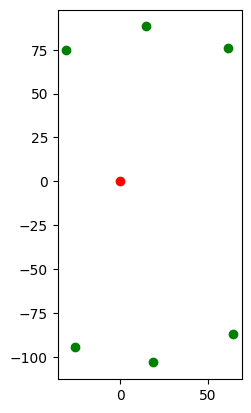

In [45]:

x = MotorLocations[:,0]
y = MotorLocations[:,1]
plt.scatter(x,y,c='green')
focusat0 = np.array([[0,0,0]]) # Test locaton at the center of the lanmark
x = focusat0[0,0]
y = focusat0[0,1]
plt.scatter(x,y,c='red')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [202]:
trajfile = r'D:\Shirshak\Research\BabelBrain\Tests\3880\traj_location_0.txt'
traj_slicer = read_itk_affine_transform(trajfile)
print(itk_to_BSight(traj_slicer))

[[-6.14029057e-01  6.95124354e-01 -3.73858864e-01  6.93176572e+00]
 [ 1.94701131e-02  4.86864519e-01  8.73260474e-01 -1.43584013e+01]
 [-7.89043238e-01 -5.28928231e-01  3.12483111e-01  3.51675443e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [209]:
import math
print(math.sqrt(math.pow(2.21,2)+math.pow(2.94,2)))

3.6780021750945173
